# Neural Machine Translation (English To French)

**Credit: [AITS cainvas](http://cainvas.ai-tech.systems/) authors**

![](https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/english2french.gif)

Language Translation is a key service that is needed by the people across the whole globe. A Neural Machine Translator to translate English to French using a seq2seq NLP model which uses a birectional LSTM neural network model to translate English To French.

Dataset for training the model was taken from Kaggle. Here is the [link](https://www.kaggle.com/harishreddy18/english-to-french)

## Import Libraries

In [1]:
import nltk

# download nltk packages
nltk.download('punkt')

# download stopwords
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /home/jupyter-
[nltk_data]     gunjan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
from collections import Counter
import operator
import plotly.express as px
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import nltk
import re
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, TimeDistributed, RepeatVector, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional
from tensorflow.keras.models import Model

## Import Datasets

In [3]:
# load the data
df_english = pd.read_csv('https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/small_vocab_en.csv',
                         sep = '/t', names = ['english'], engine='python')
df_french = pd.read_csv('https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/small_vocab_fr.csv',
                         sep = '/t', names = ['french'], engine='python')

# Visualizing both the data frames

In [4]:
df_english

english
0       new jersey is sometimes quiet during autumn , ...
1       the united states is usually chilly during jul...
2       california is usually quiet during march , and...
3       the united states is sometimes mild during jun...
4       your least liked fruit is the grape , but my l...
...                                                   ...
137855  france is never busy during march , and it is ...
137856  india is sometimes beautiful during spring , a...
137857  india is never wet during summer , but it is s...
137858  france is never chilly during january , but it...
137859  the orange is her favorite fruit , but the ban...

[137860 rows x 1 columns]

In [5]:
df_french

french
0       new jersey est parfois calme pendant l' automn...
1       les états-unis est généralement froid en juill...
2       california est généralement calme en mars , et...
3       les états-unis est parfois légère en juin , et...
4       votre moins aimé fruit est le raisin , mais mo...
...                                                   ...
137855  la france est jamais occupée en mars , et il e...
137856  l' inde est parfois belle au printemps , et il...
137857  l' inde est jamais mouillé pendant l' été , ma...
137858  la france est jamais froid en janvier , mais i...
137859  l'orange est son fruit préféré , mais la banan...

[137860 rows x 1 columns]

In [6]:
df_english.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137860 entries, 0 to 137859
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   english  137860 non-null  object
dtypes: object(1)
memory usage: 1.1+ MB


In [7]:
df_french.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137860 entries, 0 to 137859
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   french  137860 non-null  object
dtypes: object(1)
memory usage: 1.1+ MB


# Concatinating both English and French dataframe into a single DataFrame

In [8]:
df = pd.concat([df_english, df_french], axis = 1)

In [9]:
df

english  \
0       new jersey is sometimes quiet during autumn , ...   
1       the united states is usually chilly during jul...   
2       california is usually quiet during march , and...   
3       the united states is sometimes mild during jun...   
4       your least liked fruit is the grape , but my l...   
...                                                   ...   
137855  france is never busy during march , and it is ...   
137856  india is sometimes beautiful during spring , a...   
137857  india is never wet during summer , but it is s...   
137858  france is never chilly during january , but it...   
137859  the orange is her favorite fruit , but the ban...   

                                                   french  
0       new jersey est parfois calme pendant l' automn...  
1       les états-unis est généralement froid en juill...  
2       california est généralement calme en mars , et...  
3       les états-unis est parfois légère en juin , et...  
4       votre moins aimé fruit est le raisin , mais mo...  
...                                                   ...  
137855  la france est jamais occupée en mars , et il e...  
137856  l' inde est parfois belle au printemps , et il...  
137857  l' inde est jamais mouillé pendant l' été , ma...  
137858  la france est jamais froid en janvier , mais i...  
137859  l'orange est son fruit préféré , mais la banan...  

[137860 rows x 2 columns]

In [10]:
#printing total records
print('Total English records = {}'.format(len(df['english'])))
print('Total French records = {}'.format(len(df['french'])))

Total English records = 137860
Total French records = 137860


# Performing Data Cleaning

In [12]:
# function to remove punctuations
def remove_punc(x):
    return re.sub('[!#?,.:";]', '', x)

In [13]:
df['french'] = df['french'].apply(remove_punc)
df['english'] = df['english'].apply(remove_punc)

In [14]:
english_words = []
french_words  = []

# Finding out total unique words in our English and French Vocabulary

In [15]:
def get_unique_words(x, word_list):
    for word in x.split():
        if word not in word_list:
            word_list.append(word)
            
df['english'].apply(lambda x: get_unique_words(x, english_words))    
total_english_words = len(english_words)
total_english_words

199

In [16]:
# number of unique words in french
df['french'].apply(lambda x: get_unique_words(x, french_words))  
total_french_words = len(french_words)
total_french_words

350

# VISUALIZE CLEANED UP DATASET

In [17]:
# Obtain list of all words in the dataset
words = []
for i in df['english']:
    for word in i.split():
        words.append(word)
    

In [18]:
# Obtain the total count of words
english_words_counts = Counter(words)


In [19]:
# sort the dictionary by values
english_words_counts = sorted(english_words_counts.items(), key = operator.itemgetter(1), reverse = True)

In [20]:
#finding out each word count in our data
english_words_counts

[('is', 205858),
 ('in', 75525),
 ('it', 75137),
 ('during', 74933),
 ('the', 67628),
 ('but', 63987),
 ('and', 59850),
 ('sometimes', 37746),
 ('usually', 37507),
 ('never', 37500),
 ('favorite', 28332),
 ('least', 27564),
 ('fruit', 27192),
 ('most', 14934),
 ('loved', 14166),
 ('liked', 14046),
 ('new', 12197),
 ('paris', 11334),
 ('india', 11277),
 ('united', 11270),
 ('states', 11270),
 ('california', 11250),
 ('jersey', 11225),
 ('france', 11170),
 ('china', 10953),
 ('he', 10786),
 ('she', 10786),
 ('grapefruit', 10692),
 ('your', 9734),
 ('my', 9700),
 ('his', 9700),
 ('her', 9700),
 ('fall', 9134),
 ('june', 9133),
 ('spring', 9102),
 ('january', 9090),
 ('winter', 9038),
 ('march', 9023),
 ('autumn', 9004),
 ('may', 8995),
 ('nice', 8984),
 ('september', 8958),
 ('july', 8956),
 ('april', 8954),
 ('november', 8951),
 ('summer', 8948),
 ('december', 8945),
 ('february', 8942),
 ('our', 8932),
 ('their', 8932),
 ('freezing', 8928),
 ('pleasant', 8916),
 ('beautiful', 8915),
 ('

In [21]:
# append the values to a list for visualization purposes
english_words = []
english_counts = []
for i in range(len(english_words_counts)):
    english_words.append(english_words_counts[i][0])
    english_counts.append(english_words_counts[i][1])

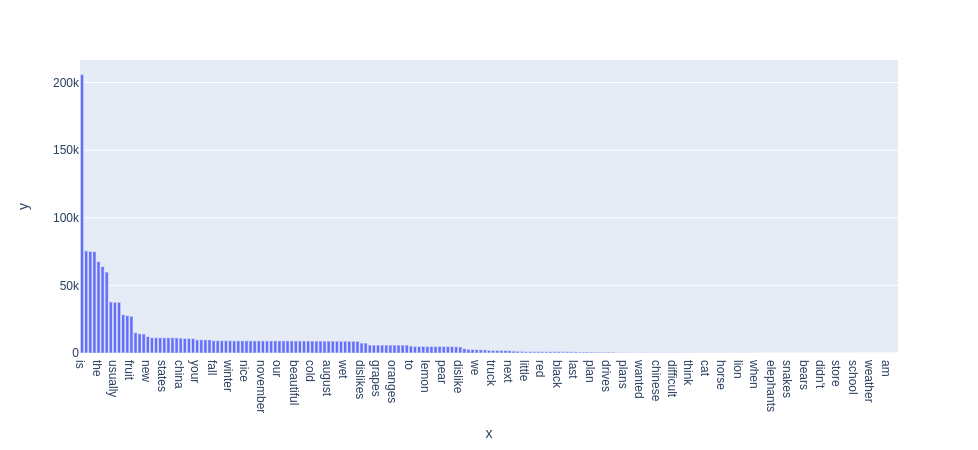

In [22]:
# Plot barplot using plotly 
fig = px.bar(x = english_words, y = english_counts)
fig.show()

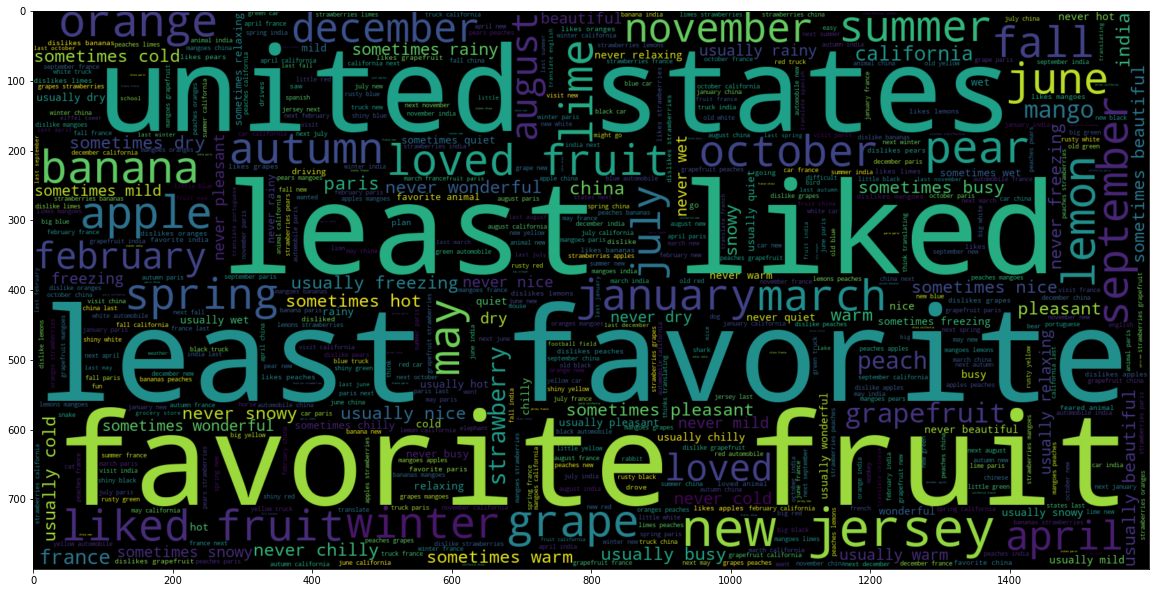

In [23]:
# plot the word cloud for text that is Real
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000, width = 1600, height = 800 ).generate(" ".join(df.english))
plt.imshow(wc, interpolation = 'bilinear')

In [24]:
#Tokenized form of first record
df.english[0]
nltk.word_tokenize(df.english[0])

['new',
 'jersey',
 'is',
 'sometimes',
 'quiet',
 'during',
 'autumn',
 'and',
 'it',
 'is',
 'snowy',
 'in',
 'april']

In [25]:
# Maximum length (number of words) per record. We will need it later for embeddings
maxlen_english = -1
for doc in df.english:
    tokens = nltk.word_tokenize(doc)
    if(maxlen_english < len(tokens)):
        maxlen_english = len(tokens)
print("The maximum number of words in any record = ", maxlen_english)

The maximum number of words in any record =  15


# Doing similar operations on French data

In [26]:
words = []
for i in df['french']:
    for word in i.split():
        words.append(word)

In [27]:
french_words_counts = Counter(words)

In [28]:
# sort the dictionary by values and printing
french_words_counts = sorted(french_words_counts.items(), key = operator.itemgetter(1), reverse = True)

french_words_counts



[('est', 196809),
 ('en', 105768),
 ('il', 84079),
 ('les', 65255),
 ('mais', 63987),
 ('et', 59851),
 ('la', 49861),
 ('parfois', 37746),
 ('jamais', 37215),
 ('le', 35306),
 ("l'", 32917),
 ('généralement', 31292),
 ('moins', 27557),
 ('aimé', 25852),
 ('au', 25738),
 ('fruit', 23626),
 ('préféré', 23305),
 ('agréable', 17751),
 ('froid', 16794),
 ('son', 16496),
 ('chaud', 16405),
 ('de', 15070),
 ('plus', 14934),
 ('automne', 14727),
 ('mois', 14350),
 ('à', 13870),
 ('elle', 12056),
 ('citrons', 11679),
 ('paris', 11334),
 ('inde', 11277),
 ('états-unis', 11210),
 ('france', 11170),
 ('jersey', 11052),
 ('new', 11047),
 ('chine', 10936),
 ('pendant', 10741),
 ('pamplemousse', 10140),
 ('mon', 9403),
 ('votre', 9368),
 ('juin', 9133),
 ('printemps', 9100),
 ('janvier', 9090),
 ('hiver', 9038),
 ('mars', 9023),
 ('été', 8999),
 ('mai', 8995),
 ('septembre', 8958),
 ('juillet', 8956),
 ('avril', 8954),
 ('novembre', 8951),
 ('décembre', 8945),
 ('février', 8942),
 ('octobre', 8911),


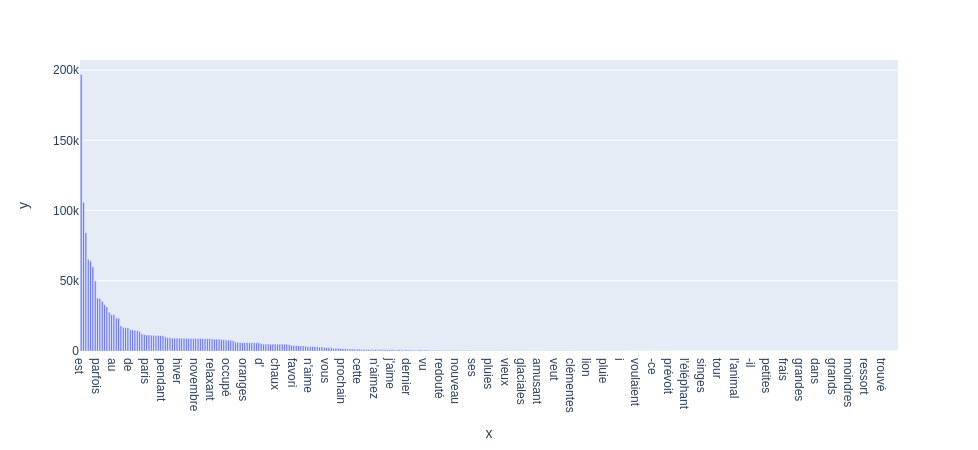

In [29]:
# append the values to a list for visuaization purpose
french_words = []
french_counts = []
for i in range(len(french_words_counts)):
    french_words.append(french_words_counts[i][0])
    french_counts.append(french_words_counts[i][1])

fig = px.bar(x = french_words, y = french_counts)
fig.show()


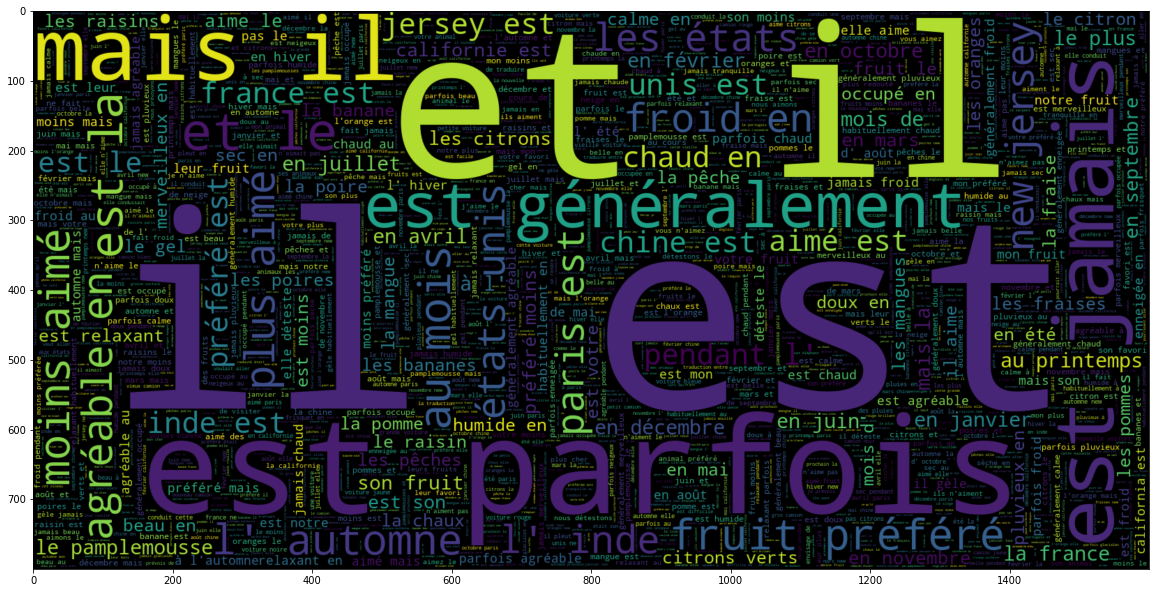

In [30]:
# plot the word cloud for French
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df.french))
plt.imshow(wc, interpolation = 'bilinear')


In [31]:
# Maximum length (number of words) per records. We will need it later for embeddings
maxlen_french = -1
for doc in df.french:
    tokens = nltk.word_tokenize(doc)
    if(maxlen_french < len(tokens)):
        maxlen_french = len(tokens)
print("The maximum number of words in any record = ", maxlen_french)

The maximum number of words in any record =  23


# Preparing the Data by Performing Tokenization and Padding

In [32]:
def tokenize_and_pad(x, maxlen):
  #  a tokenier to tokenize the words and create sequences of tokenized words
    tokenizer = Tokenizer(char_level = False)
    tokenizer.fit_on_texts(x)
    sequences = tokenizer.texts_to_sequences(x)
    padded = pad_sequences(sequences, maxlen = maxlen, padding = 'post')
    return tokenizer, sequences, padded

In [33]:
# tokenize and padding to the data 
x_tokenizer, x_sequences, x_padded = tokenize_and_pad(df.english, maxlen_english)
y_tokenizer, y_sequences, y_padded = tokenize_and_pad(df.french,  maxlen_french)

In [34]:
# Total vocab size, since we added padding we add 1 to the total word count
english_vocab_size = total_english_words + 1
print("Complete English Vocab Size:", english_vocab_size)

Complete English Vocab Size: 200


In [35]:
# Total vocab size, since we added padding we add 1 to the total word count
french_vocab_size = total_french_words + 1
print("Complete French Vocab Size:", french_vocab_size)

Complete French Vocab Size: 351


In [36]:
print("The tokenized version for document\n", df.english[-1:].item(),"\n is : ", x_padded[-1:])

The tokenized version for document
 the orange is her favorite fruit  but the banana is your favorite  
 is :  [[ 5 84  1 32 11 13  6  5 87  1 29 11  0  0  0]]


In [37]:
print("The tokenized version for document\n", df.french[-1:].item(),"\n is : ", y_padded[-1:])

The tokenized version for document
 l'orange est son fruit préféré  mais la banane est votre favori  
 is :  [[84  1 20 16 17  5  7 87  1 40 93  0  0  0  0  0  0  0  0  0  0  0  0]]


In [38]:
# function to obtain the text from padded variables
def pad_to_text(padded, tokenizer):

    id_to_word = {id: word for word, id in tokenizer.word_index.items()}
    id_to_word[0] = ''

    return ' '.join([id_to_word[j] for j in padded])

In [39]:
# Otaining the actual text back in original form.
pad_to_text(y_padded[0], y_tokenizer)

"new jersey est parfois calme pendant l' automne et il est neigeux en avril         "

# Defining the model

In [40]:
# Train test split
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_padded, y_padded, test_size = 0.1)

In [41]:
# Sequential Model
model = Sequential()
# embedding layer
model.add(Embedding(english_vocab_size, 256, input_length = maxlen_english, mask_zero = True))
# encoder
model.add(LSTM(256))
# decoder
# repeatvector repeats the input for the desired number of times to change
# 2D-array to 3D array. For example: (1,256) to (1,23,256)
model.add(RepeatVector(maxlen_french))
model.add(LSTM(256, return_sequences= True ))
model.add(TimeDistributed(Dense(french_vocab_size, activation ='softmax')))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 15, 256)           51200     
_________________________________________________________________
lstm (LSTM)                  (None, 256)               525312    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 23, 256)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 23, 256)           525312    
_________________________________________________________________
time_distributed (TimeDistri (None, 23, 351)           90207     
Total params: 1,192,031
Trainable params: 1,192,031
Non-trainable params: 0
_________________________________________________________________


In [42]:
# change the shape of target from 2D to 3D
y_train = np.expand_dims(y_train, axis = 2)
y_train.shape

(124074, 23, 1)

In [43]:
# train the model
history = model.fit(x_train, y_train, batch_size=1024, validation_split= 0.1, epochs=25)

Epoch 1/25
110/110 [==============================] - 10s 94ms/step - loss: 2.7059 - accuracy: 0.4973 - val_loss: 2.1038 - val_accuracy: 0.5381
Epoch 2/25
110/110 [==============================] - 9s 83ms/step - loss: 1.8692 - accuracy: 0.5757 - val_loss: 1.5988 - val_accuracy: 0.6029
Epoch 3/25
110/110 [==============================] - 9s 83ms/step - loss: 1.4723 - accuracy: 0.6228 - val_loss: 1.3504 - val_accuracy: 0.6453
Epoch 4/25
110/110 [==============================] - 9s 84ms/step - loss: 1.2523 - accuracy: 0.6597 - val_loss: 1.1983 - val_accuracy: 0.6677
Epoch 5/25
110/110 [==============================] - 9s 86ms/step - loss: 1.0952 - accuracy: 0.6908 - val_loss: 1.0297 - val_accuracy: 0.7072
Epoch 6/25
110/110 [==============================] - 9s 84ms/step - loss: 0.9589 - accuracy: 0.7259 - val_loss: 0.9238 - val_accuracy: 0.7331
Epoch 7/25
110/110 [==============================] - 9s 85ms/step - loss: 0.8685 - accuracy: 0.7486 - val_loss: 0.8167 - val_accuracy: 0.764

In [44]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


# Visualizing the train and test metrics

In [45]:
import matplotlib.pyplot as plt
%matplotlib inline

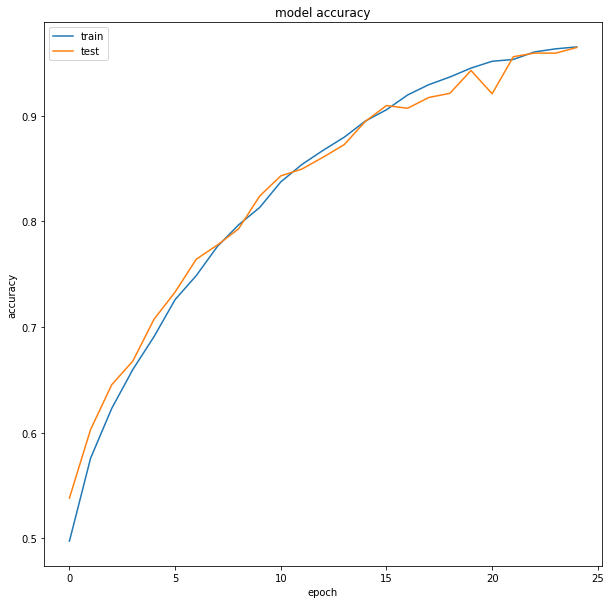

In [46]:
# summarize history for Accuracy
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

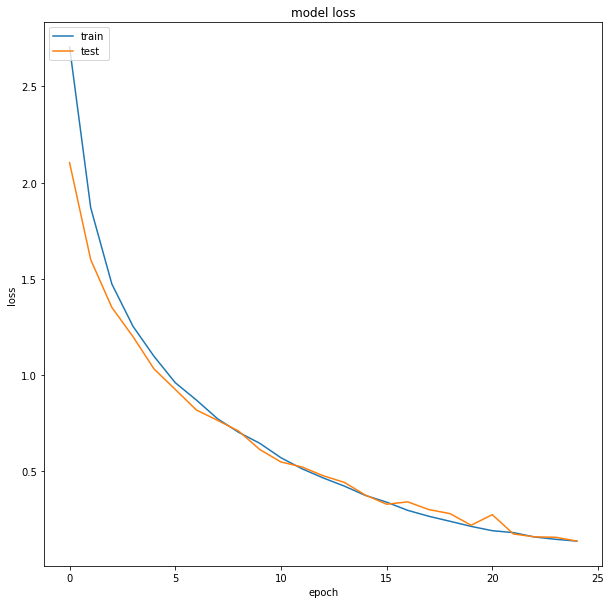

In [47]:
# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [48]:
# save the model
model.save("eng2french.h5")

# ASSESS TRAINED MODEL PERFORMANCE


In [49]:
# function to make prediction
def prediction(x, x_tokenizer = x_tokenizer, y_tokenizer = y_tokenizer):
    predictions = model.predict(x)[0]
    id_to_word = {id: word for word, id in y_tokenizer.word_index.items()}
    id_to_word[0] = ''
    return ' '.join([id_to_word[j] for j in np.argmax(predictions,1)])

In [50]:
# Printing the English text with corrent French Translation and predicted French Translation 
for i in range(5):

    print('Original English word - {}\n'.format(pad_to_text(x_test[i], x_tokenizer)))
    print('Original French word - {}\n'.format(pad_to_text(y_test[i], y_tokenizer)))
    print('Predicted French word - {}\n\n\n\n'.format(prediction(x_test[i:i+1])))

Original English word - new jersey is sometimes relaxing during may and it is never busy in april 

Original French word - new jersey est relaxant parfois au mois de mai et il est jamais occupé en avril       

Predicted French word - new jersey est relaxant parfois au mois de mai et il est jamais en en avril       




Original English word - our least favorite fruit is the grapefruit but his least favorite is the banana 

Original French word - notre fruit préféré moins est le pamplemousse mais son moins préféré est la banane         

Predicted French word - notre fruit préféré moins est le pamplemousse mais son moins préféré est la banane         




Original English word - you like grapefruit bananas and mangoes         

Original French word - vous aimez le pamplemousse les bananes et les mangues              

Predicted French word - vous aimez le pamplemousse les bananes et les mangues              




Original English word - the united states is sometimes wet during winter b

# Compliling the model to DeepC for production

In [ ]:
!deepCC eng2french.h5